<h2><center>Trabalho de conclusão do curso de Especialização em Ciência de Dados da Facens</center></h2>
<h3><center>Faculdade de Engenharia de Sorocaba</center></h3>

**Alunos:** 
<p>
<p>Dani Shizue Sakamoto - RA: 191219
<p>Mariana de Castro Pires Tavares Albuquerque - RA: 191224
<p>Tan Kim Wah - RA: 141462

<h2><center>Extração de Face Embeddings com Facenet</center></h2>

A partir das faces já submetidas ao detector facial (biblioteca MTCNN), utilizamos o modelo Facenet para extrair os Face Embeddings, a fim de realizar a classificação nas classes propostas (adulto, adolescente e criança).

In [ ]:
from platform import python_version

print(python_version()) #o modelo do Keras Face Net não funcionou com o Python 3.8, então realizei um downgrade



3.6.9


In [ ]:
#Imports
from os import listdir
from os.path import isdir
from PIL import Image
from matplotlib import pyplot
from random import choice

from numpy import asarray
from numpy import load
from numpy import expand_dims
from numpy import savez_compressed
from numpy import reshape

from keras.models import load_model

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
#load images and extract faces for all images in a directory
def load_faces(directory):
    faces = list()
    # enumerate files
    for filename in listdir(directory):
        # path
        path = directory + filename
        # get face
        face = extract_image(path)
        # store
        faces.append(face)
    return faces


#Method to extract Face
def extract_image(image):
    img1 = Image.open(image)            #open the image
    img1 = img1.convert('RGB')          #convert the image to RGB format 
    img1 = img1.resize((160,160))       #resize the image  
    pixels = asarray(img1)                  #convert the image to numpy array
    return pixels


# load a dataset that contains one subdir for each class that in turn contains images
def load_dataset(directory):
    X, y = list(), list()
    # enumerate folders, on per class
    for subdir in listdir(directory):
        # path
        path = directory + subdir + '/'
        # skip any files that might be in the dir
        if not isdir(path):
            continue
        # load all faces in the subdirectory
        faces = load_faces(path)
        # create labels
        labels = [subdir for _ in range(len(faces))]
        # summarize progress
        print('>loaded %d examples for class: %s' % (len(faces), subdir))
        # store
        X.extend(faces)
        y.extend(labels)
    return asarray(X), asarray(y)

In [ ]:
# load train dataset
trainX, trainy = load_dataset('target/train/')
print(trainX.shape, trainy.shape)
# load test dataset
testX, testy = load_dataset('target/test/')
# save arrays to one file in compressed format
savez_compressed('adience-dataset-2.npz', trainX, trainy, testX, testy)

In [ ]:
import tensorflow as tf

C:\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:544: FutureWarning: Passing (type, 1) or '1ty

In [ ]:
# calculate a face embedding for each face in the dataset using facenet

# load the facenet model
model = load_model('facenet_keras.h5')
print('Loaded Model')

# load the face dataset
data = load('adience-dataset-2.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)




Loaded Model
Loaded:  (11314, 160, 160, 3) (11314,) (4802, 160, 160, 3) (4802,)


In [ ]:

model.load_weights('facenet_keras_weights (1).h5')

In [ ]:
model.compile()

In [ ]:
#@title
model.summary()

Model: "inception_resnet_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 79, 79, 32)   0           Conv2d_1a_3x3_BatchNorm[0][0]    
________________________________________________________________________________

In [ ]:

#Generalize the data and extract the embeddings
def extract_embeddings(model,face_pixels):
  face_pixels = face_pixels.astype('float32')  #convert the entire data to float32(base)
  mean = face_pixels.mean()                    #evaluate the mean of the data
  std  = face_pixels.std()                     #evaluate the standard deviation of the data
  face_pixels = (face_pixels - mean)/std       
  samples = expand_dims(face_pixels,axis=0)    #expand the dimension of data 
  yhat = model.predict(samples)
  return yhat[0]



In [ ]:
#teste em uma face
face = extract_image('target/test/adult/landmark_aligned_face.1.11518646533_80f36f9e43_o.jpg')
embed = extract_embeddings(model, face)
print(embed)

[-2.0904958  -1.0269897   0.21296883  1.0865914   0.57428086 -0.22265734
  1.9086512  -0.6513748   0.11625776 -0.842382    0.8927227   0.42883414
 -0.9532845   0.18613583  0.3276931  -0.36083376  1.046767    0.32141083
  0.0316051  -0.64250755 -1.1311747  -1.53741    -0.49140757 -1.4525838
 -1.5784831   0.05306559  1.3914032   0.08401921 -2.202153    1.1969438
  0.68066335 -0.32222024 -0.12119119 -1.4330618   0.55525535  1.3612605
  1.4593235  -0.6138536  -0.4594161   0.58308125 -0.1218936  -1.097089
  1.096885    0.08467178  0.9751933   0.28847066  0.05770647 -1.0046011
 -0.7214423   0.8034358  -0.68951637 -0.08466578  0.793818   -0.23341492
 -0.7556265   1.7649696  -0.6181056   2.284226    1.4391376  -0.54161865
 -0.7118033   1.1781518   0.7422995   0.2164433   0.9153129   0.3538041
  0.45670527  1.1801428  -1.0498511   1.9770747   2.317079   -0.10809565
  0.6516414  -0.12767568 -0.76596546  0.5261752   0.7667384  -0.66811186
 -2.2594976   0.53803873 -0.38332957  0.88292193 -0.140272

In [ ]:
# convert each face in the train set to an embedding
newTrainX = list()
for face_pixels in trainX:
    try:
        embedding = extract_embeddings(model,face_pixels)
        newTrainX.append(embedding)
    except:
        print("Erro ao ler imagem {}".format(face_pixels))
newTrainX = asarray(newTrainX)
print(newTrainX.shape)

# convert each face in the test set to an embedding
newTestX = list()
for face_pixels in testX:
    try:
        embedding = extract_embeddings(model,face_pixels)
        newTestX.append(embedding)
    except:
        print("Erro ao ler imagem {}".format(face_pixels))
newTestX = asarray(newTestX)
print(newTestX.shape)

# save arrays to one file in compressed format
savez_compressed('adience-embeddings-2.npz', newTrainX, trainy, newTestX, testy)

(11314, 128)
(4802, 128)


Predicted: teenager (61.927)
Expected: teenager


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


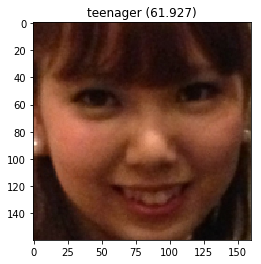

In [ ]:
# develop a classifier 

# load faces
dataset = load('adience-dataset-2.npz')
testX_faces = dataset['arr_2']
# load face embeddings
data = load('adience-embeddings-2.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)
# fit model
model = SVC(kernel='linear', probability=True)
model.fit(trainX, trainy)
# test model on a random example from the test dataset
selection = choice([i for i in range(testX.shape[0])])
random_face_pixels = testX_faces[selection]
random_face_emb = testX[selection]
random_face_class = testy[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])
# prediction for the face
samples = expand_dims(random_face_emb, axis=0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)
# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Expected: %s' % random_face_name[0])
# plot for fun
pyplot.imshow(random_face_pixels)
title = '%s (%.3f)' % (predict_names[0], class_probability)
pyplot.title(title)
pyplot.show()

In [ ]:
#Verifica a performance do treinamento

train_prediction = model.predict(trainX)
test_prediction = model.predict(testX)

labels = ['adult', 'child', 'teenager']
print('Performance do Treinamento')
print(classification_report(trainy, train_prediction, target_names = labels))
print()

print('Performance do Teste')
print(classification_report(testy, test_prediction, target_names = labels))

In [ ]:
#Imprime a matriz de confusão
print('Matriz de Confusão do Treinamento')
print(confusion_matrix(trainy, train_prediction))

print()

print('Matriz de Confusão do Teste')
print(confusion_matrix(testy, test_prediction))


Matriz de Confusão do Treinamento
[[5877   64  157]
 [ 123 3902   50]
 [ 497   85  559]]

Matriz de Confusão do Teste
[[2517   33   57]
 [  44 1641   30]
 [ 218   34  228]]


In [ ]:
T